In [780]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot

import statsmodels.api as sm
import scipy.stats as stats

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline


In [781]:
df = pd.read_csv('/Users/gabriellanemeth/Documents/METIS/Reg_course_project_local/movies_data_clean.csv', index_col = "Title")

In [782]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4068 entries, Harry Potter and the Sorcerer's Stone to Funhouse
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   domestic_gross        4068 non-null   int64  
 1   international_gross   4068 non-null   int64  
 2   running_time          4068 non-null   float64
 3   release_date          3719 non-null   object 
 4   MPAA                  3691 non-null   object 
 5   distributor           3987 non-null   object 
 6   in_release_days       4068 non-null   int64  
 7   genres                4068 non-null   object 
 8   budget                4068 non-null   float64
 9   director              4068 non-null   object 
 10  Op_weekend_gr         4068 non-null   float64
 11  theatre               4068 non-null   float64
 12  director_gender       4068 non-null   int64  
 13  total_gross           4068 non-null   int64  
 14  top_distributor       4068 non-null  

In [783]:
df.columns

Index(['domestic_gross', 'international_gross', 'running_time', 'release_date',
       'MPAA', 'distributor', 'in_release_days', 'genres', 'budget',
       'director', 'Op_weekend_gr', 'theatre', 'director_gender',
       'total_gross', 'top_distributor', 'genres_action', 'genres_drama',
       'genres_comedy', 'genres_thriller', 'genres_romance', 'peak_season_rel',
       'G', 'NC-17', 'Not Rated', 'PG', 'PG-13', 'R', 'is_director_female_?'],
      dtype='object')

 The target of the model is going to be the 'total_gross' values

A smaller dataframe will be created with only the numerical features and the target. 
 Does not include:
     - object type features
     - multicollonear features (domestic and international gross)
     - features which measured after the movie was released (opening weekend gross, in_days_release)

In [784]:
df_smaller = df.loc[:,['total_gross','running_time', 'budget', 'theatre', 'top_distributor', 'genres_action', 
                       'genres_drama','genres_comedy', 'genres_thriller', 'genres_romance', 'peak_season_rel',
                       'G', 'NC-17', 'Not Rated', 'PG', 'PG-13', 'R', 'is_director_female_?']]

In [785]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [786]:
vif(df_smaller)

total_gross              2.838690
running_time            12.351961
budget                   4.999745
theatre                  5.960031
top_distributor          2.954825
genres_action            1.905130
genres_drama             3.013351
genres_comedy            2.146807
genres_thriller          1.965056
genres_romance           1.551836
peak_season_rel          1.882717
G                        1.102527
NC-17                    1.013669
Not Rated                1.008959
PG                       2.532100
PG-13                    4.843122
R                        4.564223
is_director_female_?     1.119830
dtype: float64

As all features received scores around or under 10, no features are dropped at this point.

In [787]:
# Transform the total gross with log transformation so the distribution of the target will move to normal
# The transformed data will replace the original target

df["total_gross_log"] = np.log(df["total_gross"])

Text(0.5, 1.0, 'Total_gross_log distribution')

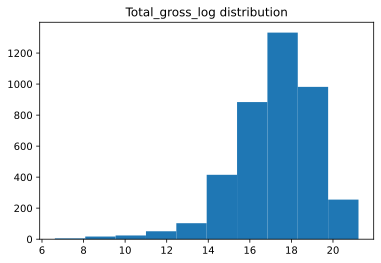

In [860]:
plt.hist(df["total_gross_log"])
plt.title('Total_gross_log distribution')

In [788]:
# As the binary columns effects won't be visible on the pairplot, it will include
# only the columns with continous numerical values 

In [789]:
df_to_pairplot3 = df.loc[:,["total_gross_log", 'running_time', 'budget', 'theatre']]

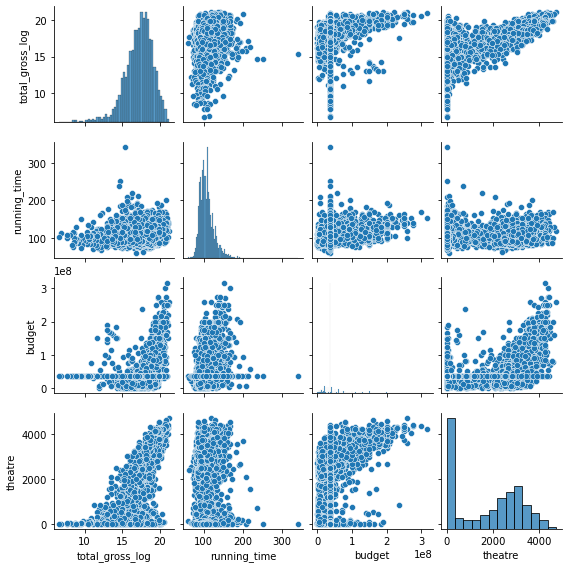

<Figure size 576x576 with 0 Axes>

In [790]:
from IPython.display import Image
import matplotlib.pyplot as plt 

sns_plot = sns.pairplot(df_to_pairplot3, height=2.0)
sns_plot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

In [791]:
df_smaller.describe()

,total_gross,running_time,budget,theatre,top_distributor,genres_action,genres_drama,genres_comedy,genres_thriller,genres_romance,peak_season_rel,G,NC-17,Not Rated,PG,PG-13,R,is_director_female_?
count,4.068000e+03,4068.000000,4.068000e+03,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000,4068.000000
mean,1.049860e+08,108.506447,4.473818e+07,1755.775320,0.482301,0.254671,0.512783,0.391593,0.275074,0.224189,0.437316,0.012045,0.001229,0.000492,0.147493,0.372173,0.373894,0.087512
std,1.800271e+08,18.966612,3.885636e+07,1423.740221,0.499748,0.435729,0.499898,0.488166,0.446606,0.417098,0.496116,0.109101,0.035041,0.022170,0.354640,0.483444,0.483895,0.282619
min,7.500000e+02,61.000000,1.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.065542e+07,95.000000,3.000000e+07,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.902438e+07,106.000000,3.500000e+07,2068.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.131464e+08,117.000000,4.000000e+07,3003.250000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.656943e+09,342.000000,3.170000e+08,4725.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [792]:
df_smaller.corr()

,total_gross,running_time,budget,theatre,top_distributor,genres_action,genres_drama,genres_comedy,genres_thriller,genres_romance,peak_season_rel,G,NC-17,Not Rated,PG,PG-13,R,is_director_female_?
total_gross,1.000000,0.228583,0.675221,0.542079,0.345122,0.256567,-0.221652,-0.029406,-0.000938,-0.103462,0.191810,0.022667,-0.014179,-0.009783,0.123298,0.139108,-0.168459,-0.055083
running_time,0.228583,1.000000,0.257049,-0.031160,0.034976,0.155860,0.262810,-0.263227,0.034454,0.041498,0.083990,-0.095375,0.016652,0.057882,-0.170799,0.044908,0.005154,-0.019172
budget,0.675221,0.257049,1.000000,0.445844,0.319629,0.358941,-0.223384,-0.067376,-0.020445,-0.119859,0.211368,0.019884,-0.021434,-0.005559,0.114084,0.166305,-0.211836,-0.066622
theatre,0.542079,-0.031160,0.445844,1.000000,0.576834,0.310480,-0.367877,0.107368,0.132830,-0.120373,0.130698,0.006908,-0.043153,-0.022439,0.194818,0.202014,-0.162406,-0.110569
top_distributor,0.345122,0.034976,0.319629,0.576834,1.000000,0.193467,-0.237276,0.083346,0.051013,-0.059993,0.101143,0.055772,-0.033860,-0.021407,0.118784,0.146345,-0.121585,-0.083039
genres_action,0.256567,0.155860,0.358941,0.310480,0.193467,1.000000,-0.231684,-0.188063,0.303276,-0.231700,0.026094,-0.054199,-0.020506,0.012489,-0.080836,0.117225,-0.036564,-0.091174
genres_drama,-0.221652,0.262810,-0.223384,-0.367877,-0.237276,-0.231684,1.000000,-0.215482,-0.019608,0.203235,-0.059724,-0.086228,0.034195,0.021619,-0.150718,-0.002394,0.151512,0.070397
genres_comedy,-0.029406,-0.263227,-0.067376,0.107368,0.083346,-0.188063,-0.215482,1.000000,-0.380286,0.223244,0.029804,0.031448,-0.028144,0.004926,0.179017,-0.036332,-0.073500,0.031354
genres_thriller,-0.000938,0.034454,-0.020445,0.132830,0.051013,0.303276,-0.019608,-0.380286,1.000000,-0.238739,-0.040346,-0.062971,-0.005898,-0.013662,-0.222067,0.007446,0.218009,-0.089467
genres_romance,-0.103462,0.041498,-0.119859,-0.120373,-0.059993,-0.231700,0.203235,0.223244,-0.238739,1.000000,-0.015247,-0.037743,0.031612,0.014668,-0.025787,0.098256,-0.058465,0.083828


No, high correlation was discovered between the features, no multicollinearity.

# Setting up for modeling and building a baseline

In [793]:
#Separate our features from our target

X_basic = df.loc[:,['running_time', 'budget', 'theatre', 'top_distributor', 'genres_action', 'genres_drama',
                    'genres_comedy', 'genres_thriller', 'genres_romance', 'peak_season_rel','G', 'NC-17',
                    'Not Rated', 'PG', 'PG-13', 'R', 'is_director_female_?']]

y_basic = df["total_gross_log"]

After trying the baseline model with the low correlating features, the below features were discard as they had no, or decreasing effect on the r2 score:
     - genres_thriller
     - genres_comedy
     - G
     - NC - 17
     - Not_rated

In [794]:
# New basic features / target

X_basic = df.loc[:,[ 'running_time','budget', 'theatre', 'top_distributor', 'genres_action', 'genres_drama',
                     'genres_comedy', 'genres_romance', 'peak_season_rel', 'G', 'PG', 'PG-13', 'R',
                    'is_director_female_?']]

y_basic = df["total_gross_log"]

Have a further look on the movies with female director, to compare the main features of that subset.

In [795]:
fem_df = df[df['is_director_female_?'] == 1]

In [796]:
fem_df = fem_df.loc[:,['total_gross','running_time', 'budget', 'theatre', 'top_distributor', 'genres_action', 
                       'genres_drama','genres_comedy', 'genres_thriller', 'genres_romance', 'peak_season_rel',
                       'G', 'NC-17', 'Not Rated', 'PG', 'PG-13', 'R', 'is_director_female_?']]

In [797]:
fem_df.describe()

,total_gross,running_time,budget,theatre,top_distributor,genres_action,genres_drama,genres_comedy,genres_thriller,genres_romance,peak_season_rel,G,NC-17,Not Rated,PG,PG-13,R,is_director_female_?
count,3.560000e+02,356.000000,3.560000e+02,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.0,356.000000,356.000000,356.000000,356.0
mean,7.296888e+07,107.332392,3.638006e+07,1247.511236,0.348315,0.126404,0.626404,0.441011,0.146067,0.337079,0.438202,0.011236,0.002809,0.0,0.174157,0.356742,0.345506,1.0
std,1.496813e+08,18.912078,2.763587e+07,1386.335472,0.477107,0.332772,0.484439,0.497207,0.353671,0.473377,0.496865,0.105551,0.053000,0.0,0.379778,0.479712,0.476202,0.0
min,5.208000e+03,72.000000,1.000000e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
25%,6.190991e+06,94.000000,2.650000e+07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
50%,2.019995e+07,104.000000,3.500000e+07,371.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
75%,6.621643e+07,115.000000,3.500000e+07,2608.500000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.0
max,1.450027e+09,252.000000,1.800000e+08,4440.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.0


In [798]:
fem_df.corr()

,total_gross,running_time,budget,theatre,top_distributor,genres_action,genres_drama,genres_comedy,genres_thriller,genres_romance,peak_season_rel,G,NC-17,Not Rated,PG,PG-13,R,is_director_female_?
total_gross,1.000000,0.123155,0.545851,0.502796,0.302775,0.294532,-0.168379,0.093041,-0.016564,-0.045121,0.176013,-0.020966,-0.002087,NaN,0.121394,0.041884,-0.095599,NaN
running_time,0.123155,1.000000,0.153454,-0.002723,0.099833,0.147520,0.208665,-0.160599,0.056121,0.055440,0.097770,-0.127468,0.139582,NaN,-0.123780,0.047491,-0.078133,NaN
budget,0.545851,0.153454,1.000000,0.344375,0.299988,0.451337,-0.249385,0.055070,0.030186,-0.118343,0.235303,0.028468,-0.041118,NaN,0.131897,0.059480,-0.147852,NaN
theatre,0.502796,-0.002723,0.344375,1.000000,0.657783,0.342534,-0.292799,0.160236,0.070007,-0.043693,0.151041,-0.023409,-0.047789,NaN,0.189095,0.220692,-0.203466,NaN
top_distributor,0.302775,0.099833,0.299988,0.657783,1.000000,0.254173,-0.264155,0.122482,0.031512,0.039940,0.114822,-0.077934,-0.038802,NaN,0.115112,0.255557,-0.196424,NaN
genres_action,0.294532,0.147520,0.451337,0.342534,0.254173,1.000000,-0.212973,-0.082495,0.321368,-0.181834,0.055896,-0.040549,-0.020189,NaN,-0.040947,0.104934,-0.045289,NaN
genres_drama,-0.168379,0.208665,-0.249385,-0.292799,-0.264155,-0.212973,1.000000,-0.202853,0.039902,0.169900,-0.020119,-0.027854,0.040988,NaN,-0.181237,0.017535,0.158156,NaN
genres_comedy,0.093041,-0.160599,0.055070,0.160236,0.122482,-0.082495,-0.202853,1.000000,-0.271243,0.252272,0.002306,-0.094685,-0.047142,NaN,0.054559,0.011711,-0.014805,NaN
genres_thriller,-0.016564,0.056121,0.030186,0.070007,0.031512,0.321368,0.039902,-0.271243,1.000000,-0.210790,-0.028638,-0.044088,0.128328,NaN,-0.147983,-0.025744,0.084192,NaN
genres_romance,-0.045121,0.055440,-0.118343,-0.043693,0.039940,-0.181834,0.169900,0.252272,-0.210790,1.000000,-0.114785,-0.019637,0.074431,NaN,0.001584,0.114011,-0.055741,NaN


No significant difference between the main features of only female directors, and the total dataset

Next step to create and alternative dataset where no information given for the director's gender and see how the r2 scores performs on the two dataset

In [799]:
X_no_gender = df.loc[:,[ 'running_time','budget', 'theatre', 'top_distributor', 'genres_action', 'genres_drama',
                     'genres_comedy', 'genres_romance', 'peak_season_rel', 'G', 'PG', 'PG-13', 'R']]

In [800]:
X_no_gender.shape

(4068, 13)

In [801]:
X_no_gender, X_no_gender_test, y_no_gender, y_no_gender_test = train_test_split(X_no_gender, y_basic, test_size=0.2, random_state=40)

In [803]:
X_no_gender_train, X_no_gender_val, y_no_gender_train, y_no_gender_val = train_test_split(X_no_gender, y_no_gender, test_size=0.25, random_state=40)

In [804]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_no_gender_train, y_no_gender_train)
print(lr.score(X_no_gender_train, y_no_gender_train))
print(lr.score(X_no_gender_val, y_no_gender_val))

0.5401399690868459
0.4923375016435064


In [805]:
y_basic.shape

(4068,)

In [806]:
X_basic.shape

(4068, 14)

In [807]:
X = X_basic.copy()
y = y_basic.copy()

In [808]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [809]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [810]:
X_train.shape

(2440, 14)

In [811]:
X_val.shape

(814, 14)

In [812]:
X_test.shape

(814, 14)

In [813]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.540457461100534

In [814]:
# Score on validation set
lr.score(X_val,y_val)

0.492324920663854

The r2 score the same on no_gender and total dataset and gender's corralation is low with all other features. It assumed that the director's gender doesn't have visible effect on the total gross in this model.

Check some further metrics of the baseline model below:

In [816]:
print(lr.intercept_)
print(lr.coef_)

12.145046731006243
[ 2.14483891e-02  3.99098774e-09  7.89218580e-04  2.22707816e-01
  5.96964290e-02  2.26583139e-01  2.15515130e-01  1.01716117e-01
 -7.19843336e-02  1.17408011e+00  9.61140774e-01  9.84560795e-01
  9.86618906e-01 -1.24127957e-01]


In [817]:
preds = lr.predict(X_basic)

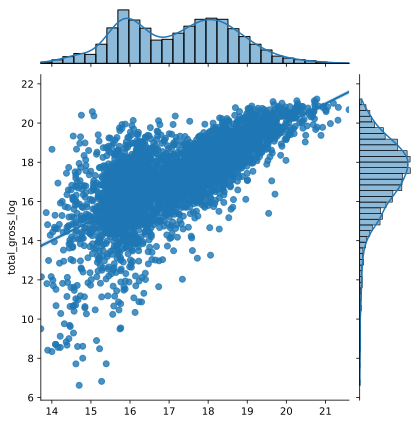

In [818]:
sns.jointplot(x=preds,y=y_basic, kind='reg')

In [819]:
def SSE(actuals, preds):
    return np.sum((actuals - preds)**2)

SSE(y_basic,preds)

7150.6020247609595

In [820]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

RMSE(y_basic,preds)

1.3258085995591276

In [821]:
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

MAE(y_basic,preds)

0.9346151191784656

In [822]:
#Create the model
model = sm.OLS(y_basic, sm.add_constant(X_basic)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_gross_log   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     328.2
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:39:37   Log-Likelihood:                -6915.1
No. Observations:                4068   AIC:                         1.386e+04
Df Residuals:                    4053   BIC:                         1.395e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.3784      0.159     77.719      0.000      12.066      12.691
running_time             0.0190      0.001     14.794      0.000       0.017       0.022
budget                4.471e-09   6.71e-10      6.664      0.000    3.16e-09    5.79e-09
theatre                  0.0008    2.1e-05     36.466      0.000       0.001       0.001
top_distributor          0.2932      0.052      5.689      0.000       0.192       0.394
genres_action            0.0886      0.056      1.594      0.111      -0.020       0.197
genres_drama             0.2011      0.051      3.982      0.000       0.102       0.300
genres_comedy            0.1822      0.048      3.803      0.000       0.088       0.276
genres_romance           0.0959      0.054      1.763      0.078      -0.011       0.202
peak_season_rel         -0.0731      0.043     -1.694      0.090      -0.158       0.012
G                        1.3007      0.206      6.301      0.000       0.896       1.705
PG                       0.9722      0.097     10.045      0.000       0.782       1.162
PG-13                    1.0109      0.084     12.092      0.000       0.847       1.175
R                        1.0438      0.080     12.974      0.000       0.886       1.202
is_director_female_?    -0.1034      0.074     -1.388      0.165      -0.249       0.043
==============================================================================
Omnibus:                      729.816   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3240.442
Skew:                          -0.808   Prob(JB):                         0.00
Kurtosis:                       7.063   Cond. No.                     6.51e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.51e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The r2 score is low with a slight overfitting. I will try to create more features with polynomial method to find the right feature combination

In [823]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.5320719705415765

In [824]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

0.4722987308560316

The r2 score has slightly decreased, and the overfit increased in a small rate. Now we have too many features and we made our model complex.

In [725]:
# Now we have too many features, so lets use Lasso regularization to reduce the number of features to 
# get only the important ones and make the model simpler

In [825]:
# Standard scale the data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

X_val_poly_scaled = scaler.transform(X_val_poly)

# Fit a LASSO model
lasso = Lasso(alpha = 0.1)
lasso.fit(X_train_poly_scaled,y_train)
lasso.score(X_train_poly_scaled,y_train)

0.5302244043329534

In [826]:
lasso.score(X_val_poly_scaled, y_val)

0.49215741164954574

In [577]:
list(zip(poly.get_feature_names(X.columns),lasso.coef_))

[('1', 0.0),
 ('running_time', 0.20106592447863342),
 ('budget', 0.0),
 ('theatre', 0.17377565533784498),
 ('top_distributor', 0.09565965182653173),
 ('genres_action', 0.0),
 ('genres_drama', 0.0),
 ('genres_comedy', 0.0),
 ('genres_thriller', 0.0),
 ('genres_romance', 0.0),
 ('peak_season_rel', -0.0),
 ('G', 0.0),
 ('NC-17', 0.0),
 ('Not Rated', -0.0),
 ('PG', -0.0),
 ('PG-13', 0.0),
 ('R', 0.0),
 ('is_director_female_?', -0.0),
 ('running_time^2', 0.0),
 ('running_time budget', 0.0),
 ('running_time theatre', 0.0),
 ('running_time top_distributor', 0.0),
 ('running_time genres_action', 0.0),
 ('running_time genres_drama', 0.06984677374624008),
 ('running_time genres_comedy', 0.0),
 ('running_time genres_thriller', 0.0),
 ('running_time genres_romance', 0.0),
 ('running_time peak_season_rel', -0.0),
 ('running_time G', 0.0),
 ('running_time NC-17', 0.0),
 ('running_time Not Rated', -0.0),
 ('running_time PG', -0.0),
 ('running_time PG-13', 0.034573785033197746),
 ('running_time R', 0.

Regularization didn't make changes in r2 score and there are too many features in the model with increased overfitting. As the polynomial caused the high number of features, the next model not includes that method and we will stay with linear regression. What we can do to boost the r2 score, to make some feature engineering.

The training, validation and test set can stay the same as above

# Linear regression with simple feature engineering

In [827]:
X2 = X_basic.copy()
y2 = y_basic.copy()

In [828]:
X2.shape

(4068, 14)

In [829]:
y2.shape

(4068,)

In [830]:
X2["theatre_2"] = X_basic["theatre"] **2

In [831]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4068 entries, Harry Potter and the Sorcerer's Stone to Funhouse
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   running_time          4068 non-null   float64
 1   budget                4068 non-null   float64
 2   theatre               4068 non-null   float64
 3   top_distributor       4068 non-null   int64  
 4   genres_action         4068 non-null   int64  
 5   genres_drama          4068 non-null   int64  
 6   genres_comedy         4068 non-null   int64  
 7   genres_romance        4068 non-null   int64  
 8   peak_season_rel       4068 non-null   int64  
 9   G                     4068 non-null   int64  
 10  PG                    4068 non-null   int64  
 11  PG-13                 4068 non-null   int64  
 12  R                     4068 non-null   int64  
 13  is_director_female_?  4068 non-null   int64  
 14  theatre_2             4068 non-null  

In [832]:
X2, X2_test, y2, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=40)

In [833]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.25, random_state=40)

In [834]:
X2_train.shape

(2440, 15)

In [835]:
X2_val.shape

(814, 15)

In [836]:
X2_test.shape

(814, 15)

In [837]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X2_train,y2_train)
lr.score(X2_train,y2_train)


0.5624004750460876

In [838]:
lr.score(X2_val,y2_val)

0.5121887933073488

In [839]:
print(lr.intercept_)
print(lr.coef_)

12.574324176760488
[ 2.01479926e-02 -1.29904497e-09 -4.65883721e-07  2.76560500e-01
  1.04703150e-01  2.65989432e-01  1.87236537e-01  1.27540843e-01
 -9.14438790e-02  1.17503031e+00  9.54441367e-01  1.08496731e+00
  1.04565633e+00 -1.68649495e-01  2.41290829e-07]


Check if Lasso or Ridge regularization works better on our data to reduce the overfitting

In [840]:
# Standard scale the data for regularized regression
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)

X2_val_scaled = scaler.transform(X2_val)

In [844]:
lr_model_ridge = Ridge(alpha = 1000)
lr_model_ridge.fit(X2_train_scaled, y2_train)

print(lr_model_ridge.score(X2_train_scaled, y2_train))
print(lr_model_ridge.score(X2_val_scaled, y2_val))


0.5278942612294256
0.4999750435946375


In [848]:
lr_model_lasso = Lasso(alpha = 0.1)
lr_model_lasso.fit(X2_train_scaled, y2_train)

print(lr_model_lasso.score(X2_train_scaled, y2_train))
print(lr_model_lasso.score(X2_val_scaled, y2_val))


0.5255666920254902
0.48994077260398583


The regularization technics didn't increased the r2 scores but slightly reduced the overfitting with ridge regularization.

In [859]:
# Final step to run the model on the test set

X2_test_scaled = scaler.transform(X2_test)

lr_model_ridge = Ridge(alpha = 1000)
lr_model_ridge.fit(X2_test_scaled, y2_test)

print(lr_model_ridge.score(X2_test_scaled, y2_test))
print(lr.score(X2_test, y2_test))

0.46650964282431495
0.5608385296815503


Model works better without the regularization

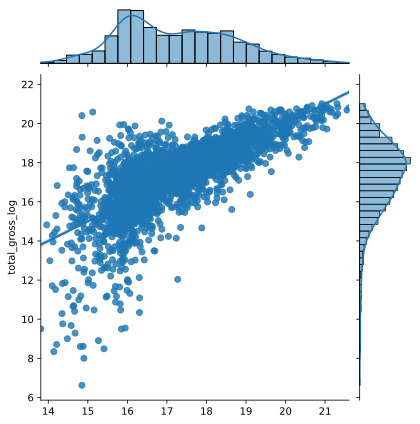

In [852]:
preds = lr.predict(X2_train) # generate predictions (on training data) using fit model

sns.jointplot(x=preds,y=y_train, kind='reg')

In [853]:
SSE(y_train,preds)

3914.91678497074

In [854]:
RMSE(y_train,preds)

1.2666783696744501

In [855]:
MAE(y_train,preds)

0.8857476368499214

In [856]:
X3 = X_basic.copy()
y3 = y_basic.copy()
model = sm.OLS(y3, sm.add_constant(X3))
model_fit = model.fit()

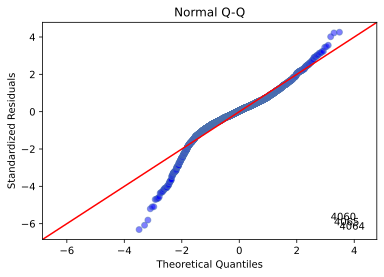

In [857]:
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));